In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import os, gc, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from colorama import Fore, Back, Style
from sklearn.decomposition import TruncatedSVD
from matplotlib.ticker import PercentFormatter

orig_dpath = "data/orig_data"

#### all data path

In [43]:
FP_CELL_METADATA = os.path.join(orig_dpath,"metadata.csv")
FP_CELL_METADATA_NEW = os.path.join(orig_dpath,"metadata_cite_day_2_donor_27678.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(orig_dpath,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(orig_dpath,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(orig_dpath,"test_cite_inputs.h5")
FP_CITE_TEST_INPUTS_NEW = os.path.join(orig_dpath,"test_cite_inputs_day_2_donor_27678.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(orig_dpath,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(orig_dpath,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(orig_dpath,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(orig_dpath,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(orig_dpath,"evaluation_ids.csv")


#### explore metadata

In [44]:
df_meta = pd.read_csv(FP_CELL_METADATA)
print("metadata shape: ", df_meta.shape)
print(len(df_meta['cell_id'].unique()), "unique cell: ")
print(len(df_meta['day'].unique()), "unique day:", df_meta['day'].unique())
print(len(df_meta['donor'].unique()), 'unique donors:', df_meta['donor'].unique())
print(len(df_meta['cell_type'].unique()), 'unique cell_type:', df_meta['cell_type'].unique())
print(len(df_meta['technology'].unique()), 'unique technology:', df_meta['technology'].unique())
print('-----any missing value:-------')
print(df_meta.isnull().sum())
df_meta.head()

metadata shape:  (281528, 5)
281528 unique cell: 
5 unique day: [ 2  3  4  7 10]
4 unique donors: [27678 32606 13176 31800]
8 unique cell_type: ['HSC' 'EryP' 'NeuP' 'MasP' 'MkP' 'BP' 'MoP' 'hidden']
2 unique technology: ['citeseq' 'multiome']
-----any missing value:-------
cell_id       0
day           0
donor         0
cell_type     0
technology    0
dtype: int64


,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq


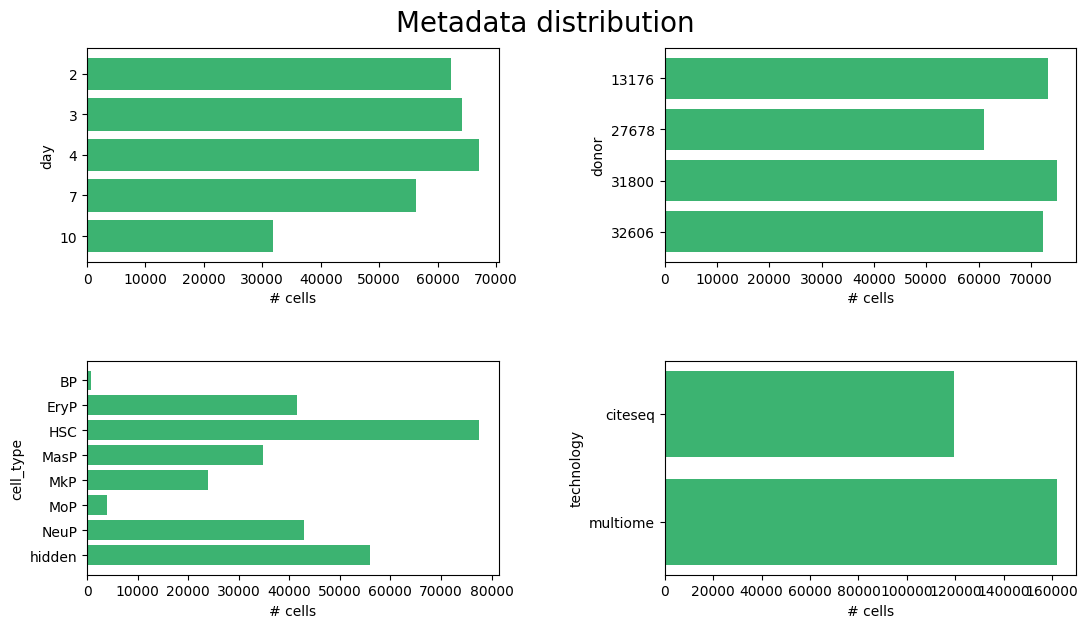

In [45]:
_, axs = plt.subplots(2, 2, figsize=(11, 6))
for col, ax in zip(['day', 'donor', 'cell_type', 'technology'], axs.ravel()):
    vc = df_meta[col].astype(str).value_counts()
    if col == 'day':
        vc.sort_index(key = lambda x : x.astype(int), ascending=False, inplace=True)
    else:
        vc.sort_index(ascending=False, inplace=True)
    ax.barh(vc.index, vc, color=['MediumSeaGreen'])
    ax.set_ylabel(col)
    ax.set_xlabel('# cells')
plt.tight_layout(h_pad=4, w_pad=4)
plt.suptitle('Metadata distribution', y=1.04, fontsize=20)
plt.show()


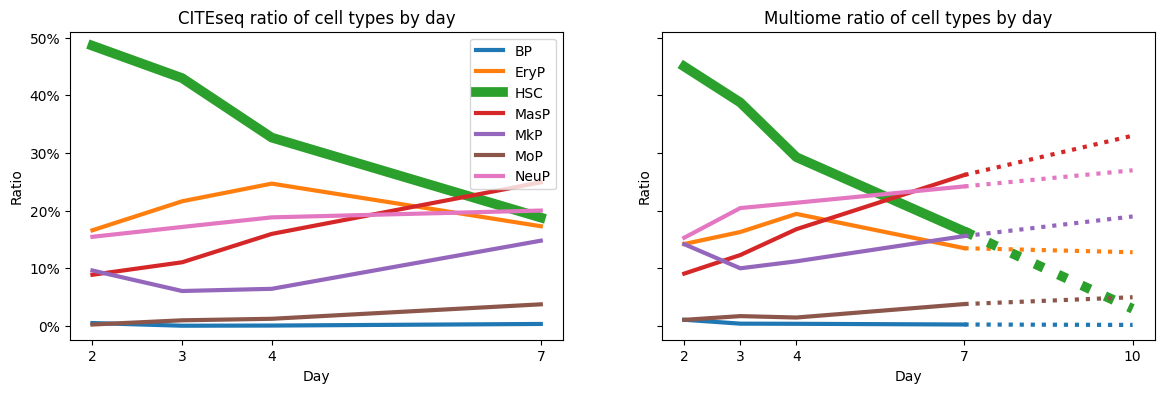

In [46]:
df_meta_cite = df_meta[df_meta.technology=="citeseq"]
df_meta_multi = df_meta[df_meta.technology=="multiome"]

daily_cell_types = df_meta_cite.groupby(['day', 'cell_type']).size().unstack()
daily_cell_types[daily_cell_types.columns] = daily_cell_types.values / daily_cell_types.values.sum(axis=1).reshape(-1, 1)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
for cell_type in daily_cell_types.columns:
    ax1.plot(daily_cell_types.index,
             daily_cell_types[cell_type],
             label=cell_type,
             lw = 7 if cell_type == 'HSC' else 3)
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
ax1.set_xticks(daily_cell_types.index)
ax1.legend()
ax1.set_xlabel('Day')
ax1.set_ylabel('Ratio')
ax1.set_title('CITEseq ratio of cell types by day')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
daily_cell_types = df_meta_multi.groupby(['day', 'cell_type']).size().unstack()
daily_cell_types.drop(columns=['hidden'], inplace=True)
daily_cell_types.drop(index=[10], inplace=True)
daily_cell_types[daily_cell_types.columns] = daily_cell_types.values / daily_cell_types.values.sum(axis=1).reshape(-1, 1)
daily_cell_types.loc[10] = [0.002, 0.128, 0.03, 0.33, 0.19, 0.05, 0.27] # estimate by visual extrapolation
for i, cell_type in enumerate(daily_cell_types.columns):
    ax2.plot(daily_cell_types.index[:-1],
             daily_cell_types[cell_type].iloc[:-1],
             label=cell_type,
             color=colors[i],
             lw = 7 if cell_type == 'HSC' else 3)
    ax2.plot(daily_cell_types.index[-2:],
             daily_cell_types[cell_type].iloc[-2:],
             color=colors[i],
             linestyle='dotted',
             lw = 7 if cell_type == 'HSC' else 3)
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
ax2.set_xticks([2,3,4,7,10])
#ax2.legend()
ax2.set_xlabel('Day')
ax2.set_ylabel('Ratio')
ax2.set_title('Multiome ratio of cell types by day')
plt.show()

del daily_cell_types


#### explore citeseq data

In [67]:
df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
print("CITE_TRAIN_INPUTS shape: ", df_cite_train_x.shape)
df_cite_train_x.head()

CITE_TRAIN_INPUTS shape:  (70988, 22050)


gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


In [48]:
print('Shape:', df_cite_train_x.shape)
print("Missing values:", df_cite_train_x.isna().sum().sum())
print("Genes which never occur in train:", (df_cite_train_x == 0).all(axis=0).sum())
print(f"Zero entries in train: {(df_cite_train_x == 0).sum().sum() / df_cite_train_x.size:.0%}")
cite_gene_names = list(df_cite_train_x.columns)


Shape: (70988, 22050)
Missing values: 0
Genes which never occur in train: 449
Zero entries in train: 78%


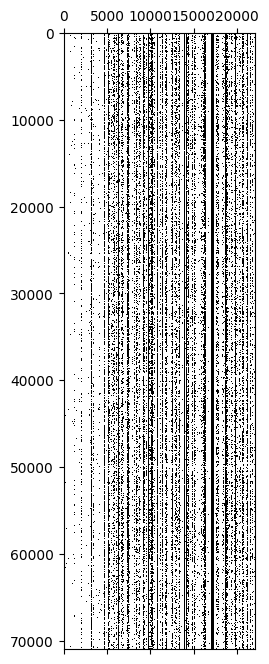

In [49]:
plt.figure(figsize=(100, 8))
plt.spy(df_cite_train_x)
plt.show()


Minimum nonzero value: 2.9715922
Maximum nonzero value: 11.579091


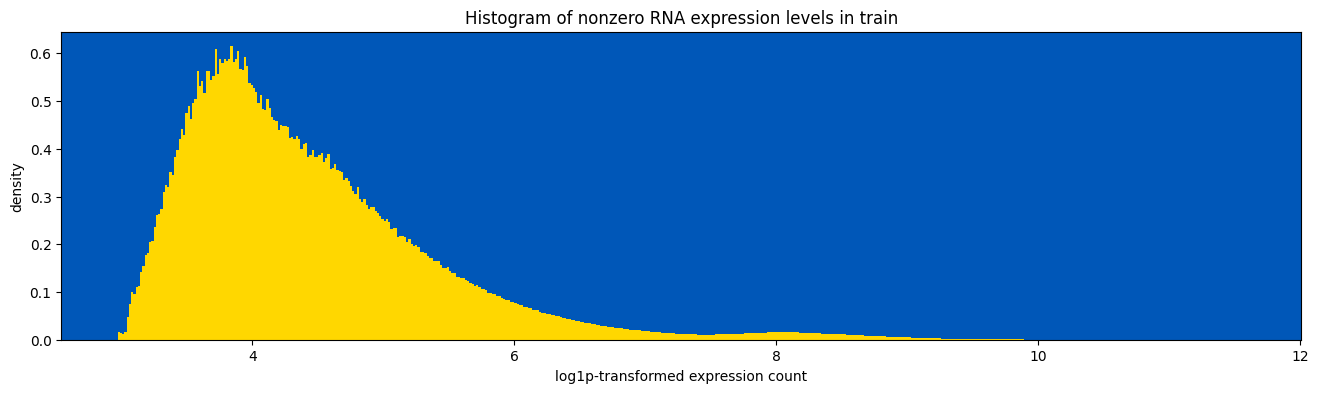

In [50]:
nonzeros = df_cite_train_x.values.ravel()
nonzeros = nonzeros[nonzeros != 0] # comment this line if you want to see the peak at zero
plt.figure(figsize=(16, 4))
plt.gca().set_facecolor('#0057b8')
plt.hist(nonzeros, bins=500, density=True, color='#ffd700')
print('Minimum nonzero value:', nonzeros.min())
print('Maximum nonzero value:', nonzeros.max())
# del nonzeros
plt.title("Histogram of nonzero RNA expression levels in train")
plt.xlabel("log1p-transformed expression count")
plt.ylabel("density")
plt.show()

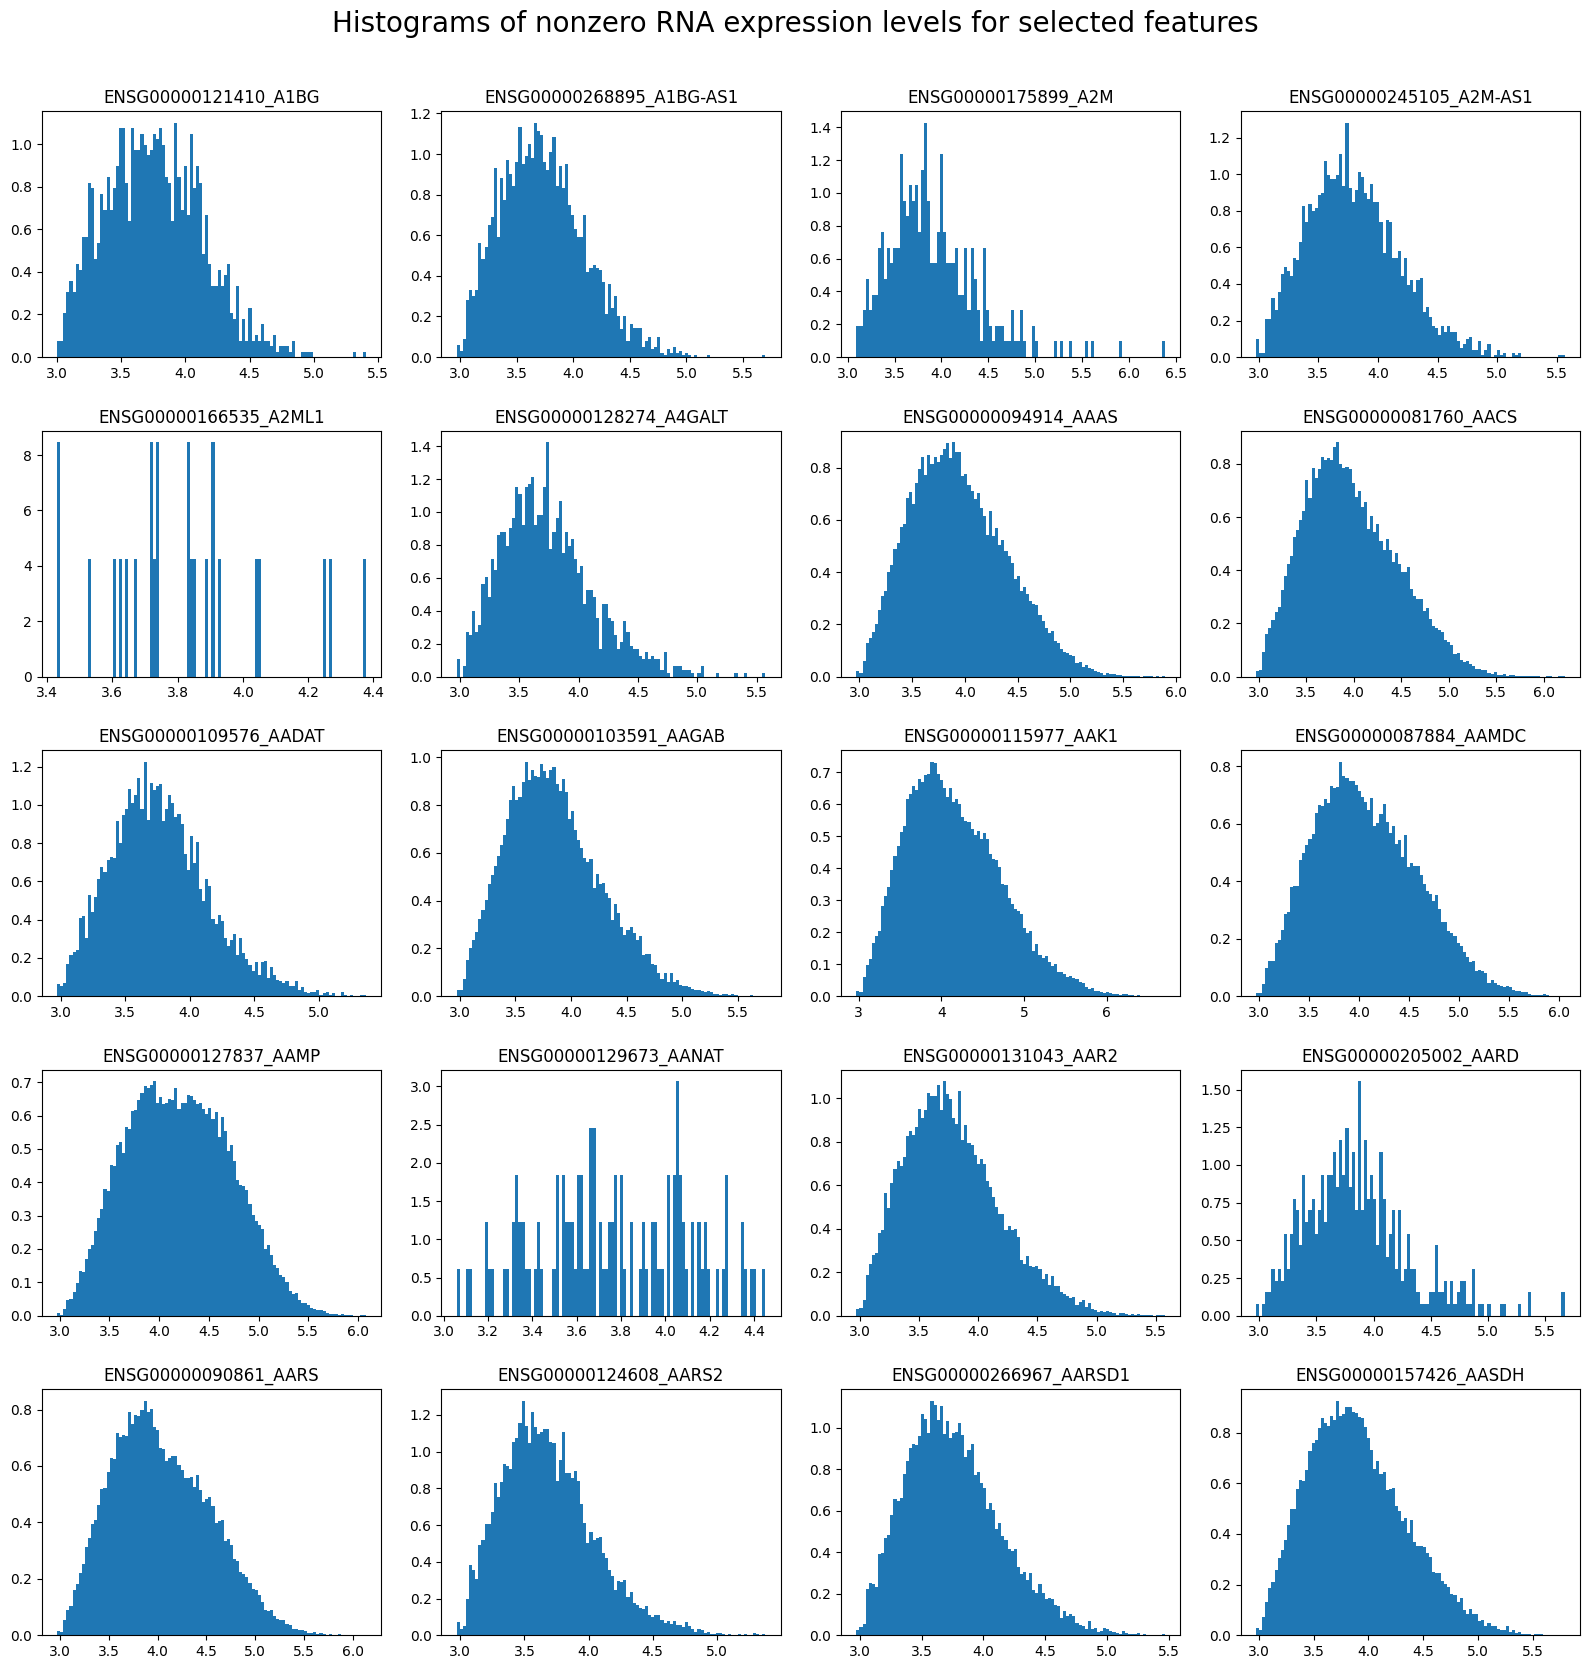

In [51]:
_, axs = plt.subplots(5, 4, figsize=(16, 16))
for col, ax in zip(df_cite_train_x.columns[:20], axs.ravel()):
    nonzeros = df_cite_train_x[col].values
    nonzeros = nonzeros[nonzeros != 0] # comment this line if you want to see the peak at zero
    ax.hist(nonzeros, bins=100, density=True)
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Histograms of nonzero RNA expression levels for selected features', fontsize=20, y=1.04)
plt.show()
del nonzeros


In [71]:
cell_index = df_cite_train_x.index
meta = df_meta_cite.set_index('cell_id').reindex(cell_index)
gc.collect()
df_cite_train_x = scipy.sparse.csr_matrix(df_cite_train_x.values)

In [73]:
df_cite_test_x = pd.read_hdf(FP_CITE_TEST_INPUTS)
print('Shape of CITEseq test:', df_cite_test_x.shape)
print("Missing values:", df_cite_test_x.isna().sum().sum())
print("Genes which never occur in test: ", (df_cite_test_x == 0).all(axis=0).sum())
print(f"Zero entries in test:  {(df_cite_test_x == 0).sum().sum() / df_cite_test_x.size:.0%}")

gc.collect()
cell_index_test = df_cite_test_x.index
meta_test = df_meta_cite.set_index('cell_id').reindex(cell_index_test)
df_cite_test_x = scipy.sparse.csr_matrix(df_cite_test_x.values)


Shape of CITEseq test: (48663, 22050)
Missing values: 0
Genes which never occur in test:  745
Zero entries in test:  78%


In [77]:
df_cite_test_x = pd.read_hdf(FP_CITE_TEST_INPUTS)
print('Shape of CITEseq test:', df_cite_test_x.shape)
print("Missing values:", df_cite_test_x.isna().sum().sum())
print("Genes which never occur in test: ", (df_cite_test_x == 0).all(axis=0).sum())
print(f"Zero entries in test:  {(df_cite_test_x == 0).sum().sum() / df_cite_test_x.size:.0%}")

gc.collect()
cell_index_test = df_cite_test_x.index
meta_test = df_meta_cite.set_index('cell_id').reindex(cell_index_test)
df_cite_test_x = scipy.sparse.csr_matrix(df_cite_test_x.values)


Shape of CITEseq test: (48663, 22050)
Missing values: 0
Genes which never occur in test:  745
Zero entries in test:  78%


#### The distributions of train and test in feature space

In [78]:
# Concatenate train and test for the SVD
both = scipy.sparse.vstack([df_cite_train_x, df_cite_test_x])
print(f"Shape of both before SVD: {both.shape}")

# Project to two dimensions
svd = TruncatedSVD(n_components=2, random_state=1)
both = svd.fit_transform(both)
print(f"Shape of both after SVD:  {both.shape}")

# Separate train and test
X = both[:df_cite_train_x.shape[0]]
Xt = both[df_cite_train_x.shape[0]:]

Shape of both before SVD: (119651, 22050)
Shape of both after SVD:  (119651, 2)


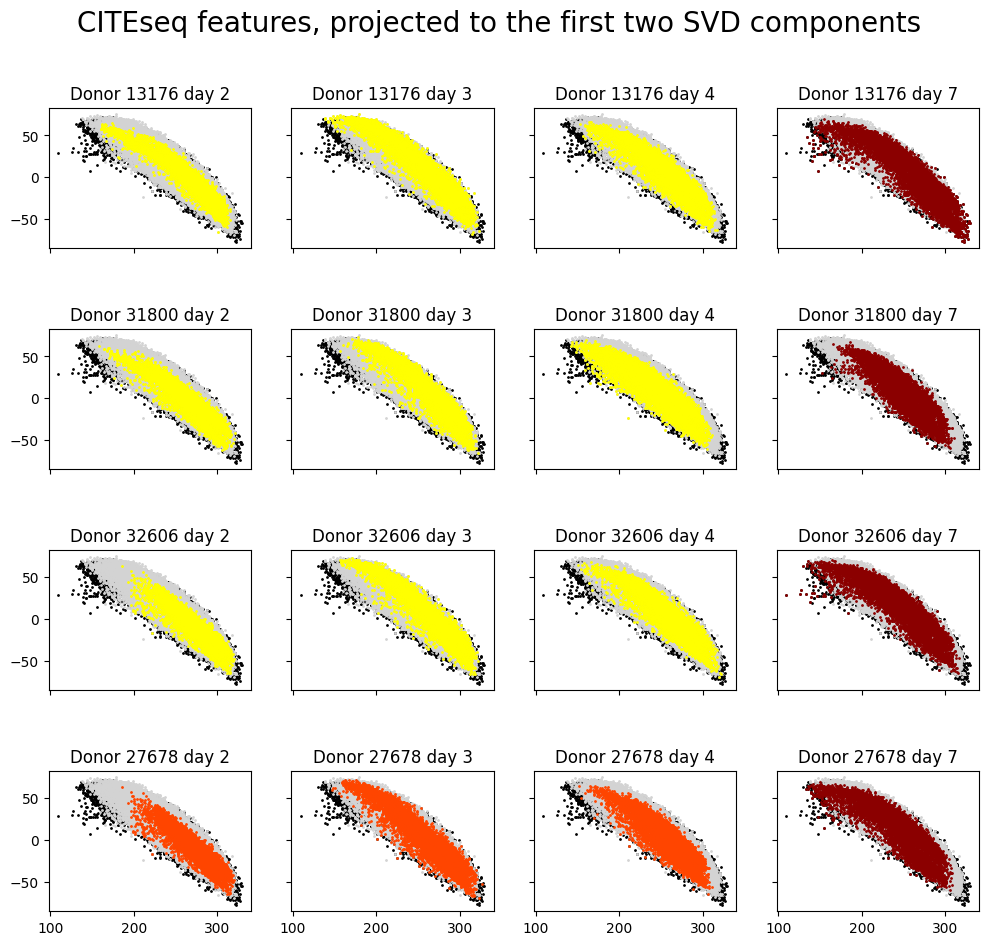

In [80]:
# Scatterplot for every day and donor
_, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 11))
for donor, axrow in zip([13176, 31800, 32606, 27678], axs):
    for day, ax in zip([2, 3, 4, 7], axrow):
        ax.scatter(Xt[:,0], Xt[:,1], s=1, c='k')
        ax.scatter(X[:,0], X[:,1], s=1, c='lightgray')
        if day != 7 and donor != 27678: # train
            temp = X[(meta.donor == donor) & (meta.day == day)]
            ax.scatter(temp[:,0], temp[:,1], s=1, c='yellow')
        else: # test
            temp = Xt[(meta_test.donor == donor) & (meta_test.day == day)]
            ax.scatter(temp[:,0], temp[:,1], s=1, c='darkred' if day == 7 else 'orangered')
        ax.set_title(f'Donor {donor} day {day}')
        ax.set_aspect('equal')
plt.suptitle('CITEseq features, projected to the first two SVD components', y=0.95, fontsize=20)
plt.show()

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445


Output shape: (70988, 140)


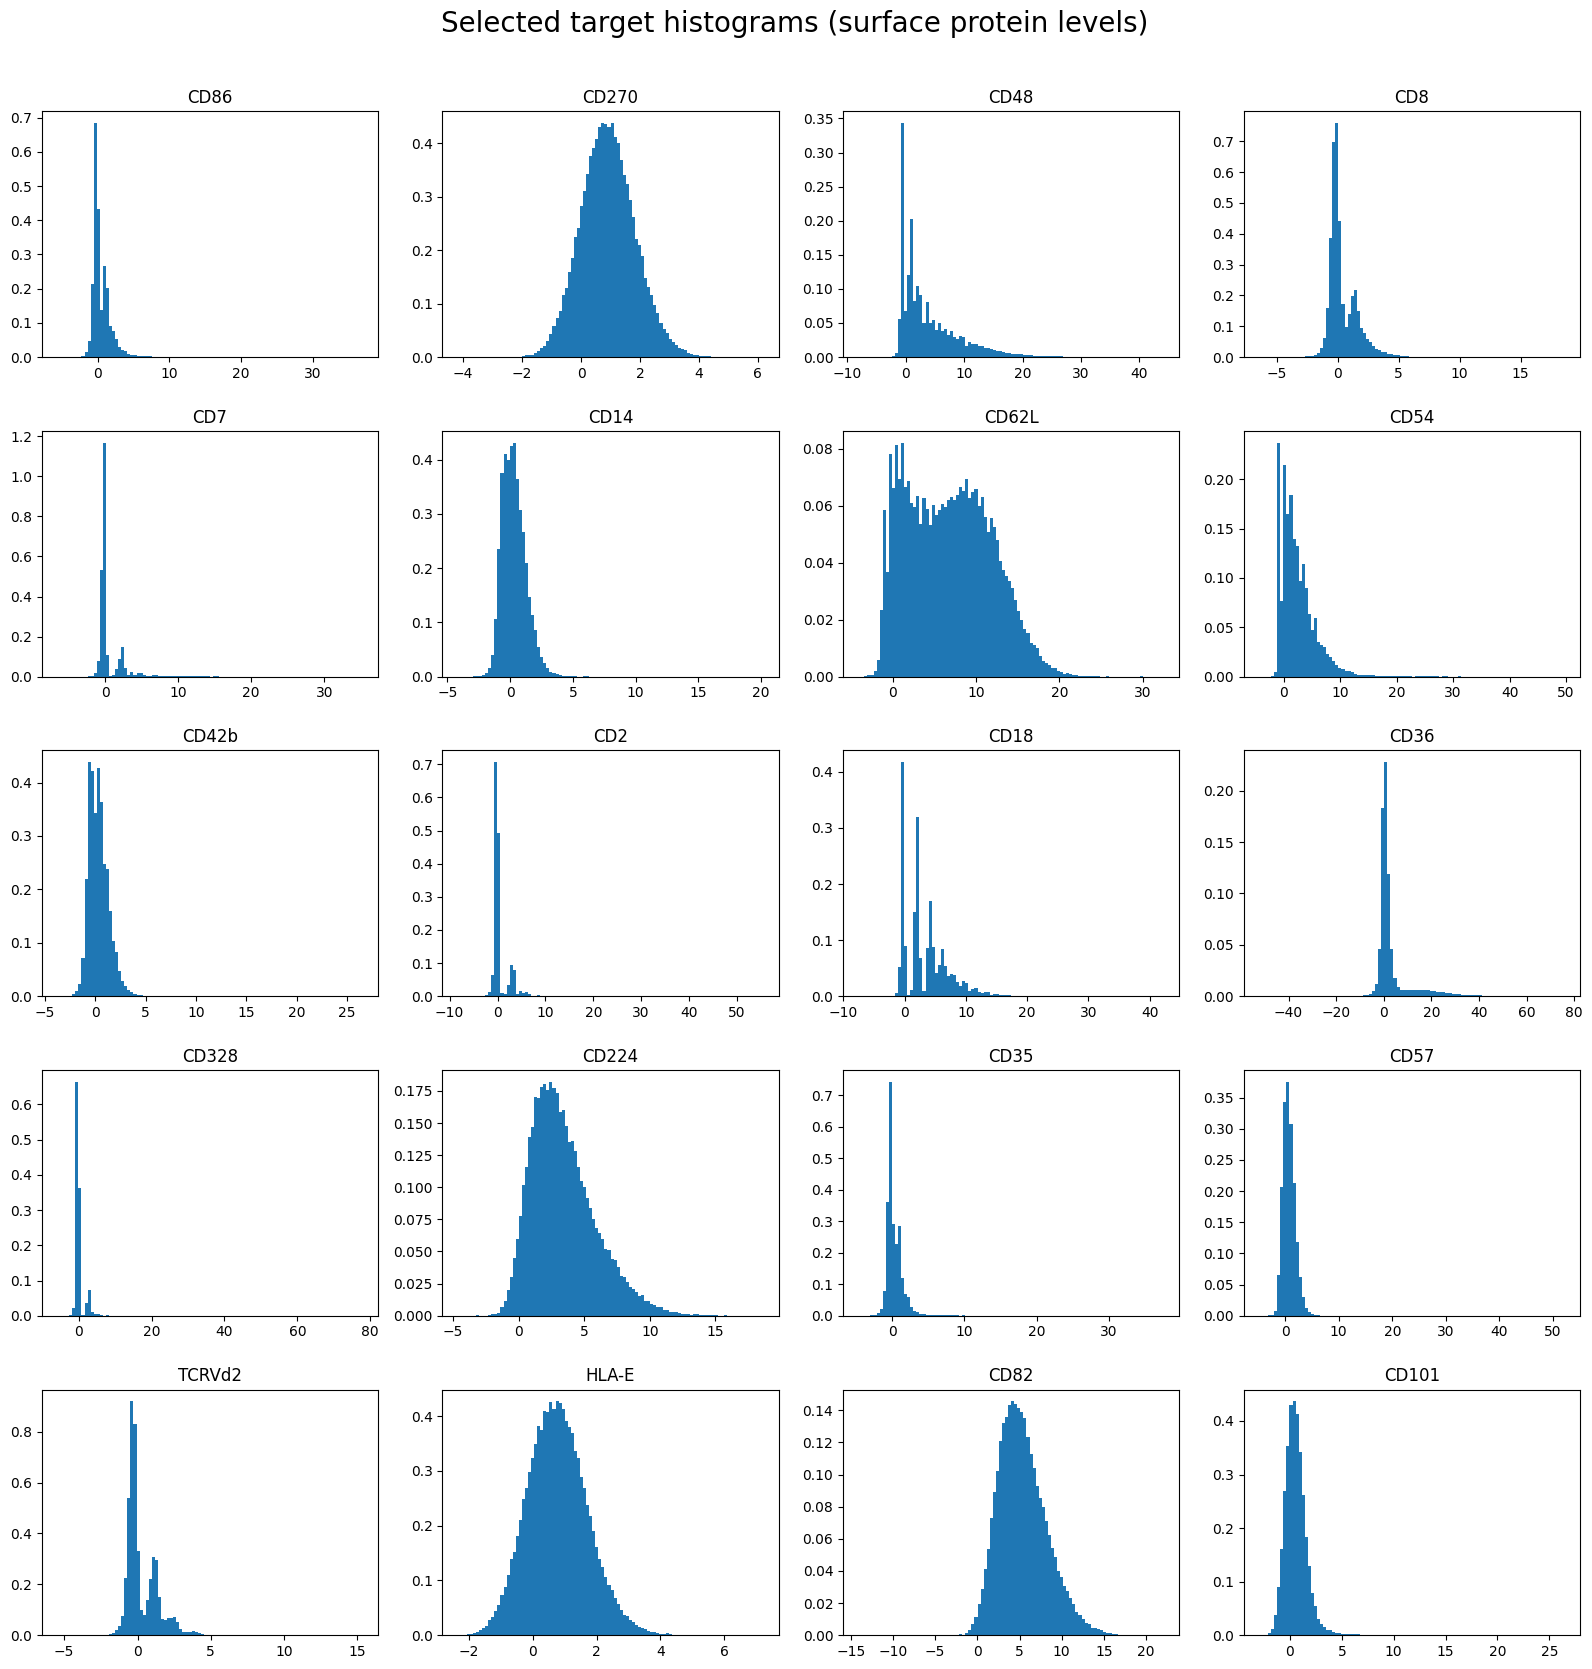

In [81]:
df_cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
display(df_cite_train_y.head())
print('Output shape:', df_cite_train_y.shape)

_, axs = plt.subplots(5, 4, figsize=(16, 16))
for col, ax in zip(['CD86', 'CD270', 'CD48', 'CD8', 'CD7', 'CD14', 'CD62L', 'CD54', 'CD42b', 'CD2', 
                    'CD18', 'CD36', 'CD328', 'CD224', 'CD35', 'CD57', 'TCRVd2', 'HLA-E', 'CD82', 'CD101'], axs.ravel()):
    ax.hist(df_cite_train_y[col], bins=100, density=True)
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Selected target histograms (surface protein levels)', fontsize=20, y=1.04)
plt.show()

cite_protein_names = list(df_cite_train_y.columns)


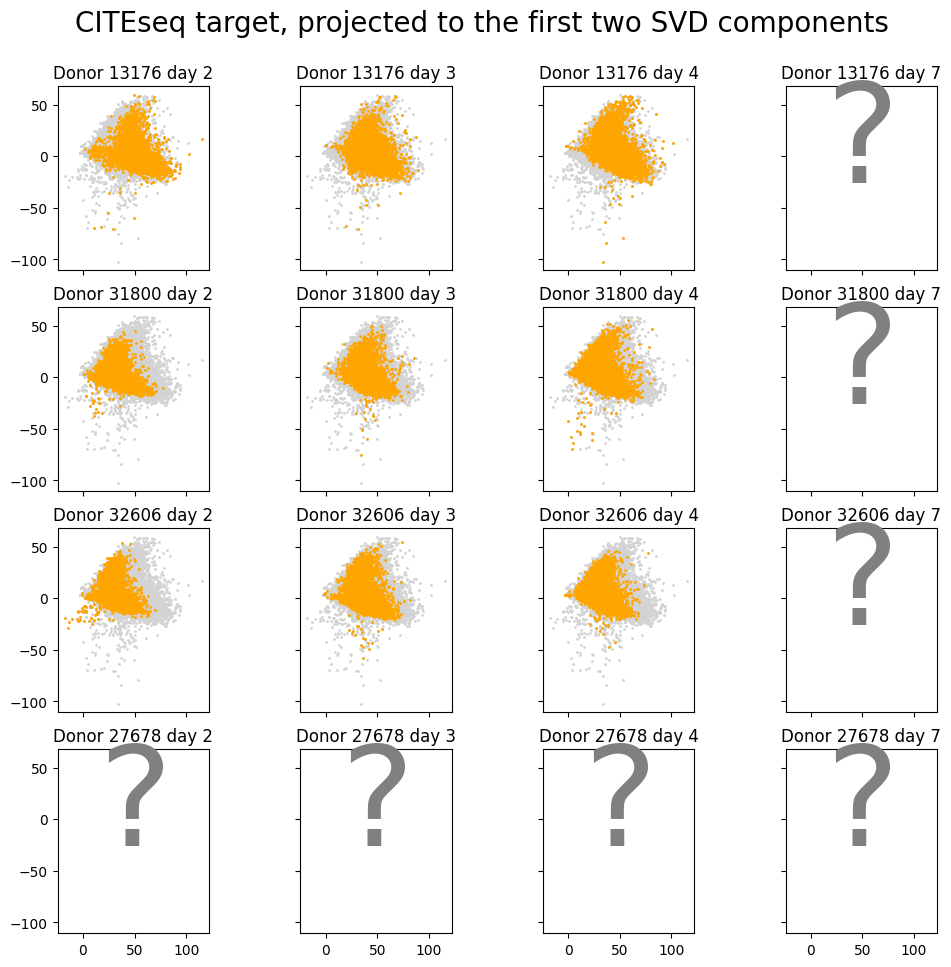

In [82]:
svd = TruncatedSVD(n_components=2, random_state=1)
X = svd.fit_transform(df_cite_train_y)

# Scatterplot for every day and donor
_, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 11))
for donor, axrow in zip([13176, 31800, 32606, 27678], axs):
    for day, ax in zip([2, 3, 4, 7], axrow):
        if day != 7 and donor != 27678: # train
            ax.scatter(X[:,0], X[:,1], s=1, c='lightgray')
            temp = X[(meta.donor == donor) & (meta.day == day)]
            ax.scatter(temp[:,0], temp[:,1], s=1, c='orange')
        else: # test
            ax.text(50, -25, '?', fontsize=100, color='gray', ha='center')
        ax.set_title(f'Donor {donor} day {day}')
        ax.set_aspect('equal')
plt.suptitle('CITEseq target, projected to the first two SVD components', y=0.95, fontsize=20)
plt.show()



In [83]:
df_cite_train_x, df_cite_train_y, X, svd = None, None, None, None # release the memory

#### Multiome

In [87]:
bins = 100
cell_summary = pd.DataFrame()

def analyze_multiome_x(filename):
    global cell_summary
    start = 0
    chunksize = 5000
    total_rows = 0
    maximum_x = 0

    while True: # read the next chunk of the file
        X = pd.read_hdf(filename, start=start, stop=start+chunksize)
        if X.isna().any().any(): print('There are missing values.')
        if (X < 0).any().any(): print('There are negative values.')
        total_rows += len(X)
        print(total_rows, 'rows read')

        donors = df_meta_multi.donor.reindex(X.index) # metadata: donor of cell
        days = df_meta_multi.day.reindex(X.index) # metadata: day of cell
        chrY_cols = [f for f in X.columns if 'chrY' in f]
        maximum_x = max(maximum_x, X[chrY_cols].values.ravel().max())
        for donor in [13176, 31800, 32606, 27678]:
            hist, _ = np.histogram(X[chrY_cols][donors == donor].values.ravel(), bins=bins, range=(0, 15))
            chrY_histo[donor] += hist

        cell_summary = pd.concat([cell_summary,
                                  pd.DataFrame({'donor': donors,
                                                'day': days,
                                                'total': X.sum(axis=1),
                                                'total_nonzero': (X != 0).sum(axis=1)})])
        if len(X) < chunksize: break
        start += chunksize

    display(X.head(3))
    print(f"Zero entries in {filename}: {(X == 0).sum().sum() / X.size:.0%}")

chrY_histo = dict()
for donor in [13176, 31800, 32606, 27678]:
    chrY_histo[donor] = np.zeros((bins, ), int)

# Look at the training data
analyze_multiome_x(FP_MULTIOME_TRAIN_INPUTS)

5000 rows read
10000 rows read
15000 rows read
20000 rows read
25000 rows read
30000 rows read
35000 rows read
40000 rows read
45000 rows read
50000 rows read
55000 rows read
60000 rows read
65000 rows read
70000 rows read
75000 rows read
80000 rows read
85000 rows read
90000 rows read
95000 rows read
100000 rows read
105000 rows read
105942 rows read


gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
13cb628b8773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0803092e6b4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.082841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e8e7ff56f262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Zero entries in data/orig_data/train_multi_inputs.h5: 98%
